# Informações do projeto

## Aluno

**Nome:** Felipe Nunes de Almeida Pereira (fnap@cin.ufpe.br)

**Github:** fnalmeidap

## Dataset

O dataset contém 100 mil observações telescópicas do espaço vindas do projeto SDSS (SLoan Digital Sky Survey). Cada observação tem 17 features e uma única classe que identifica o objeto observado como estrela, galáxia ou quasar. 

    obj_ID = Object Identifier, the unique value that identifies the object in the image catalog used by the CAS
    alpha = Right Ascension angle (at J2000 epoch)
    delta = Declination angle (at J2000 epoch)
    u = Ultraviolet filter in the photometric system
    g = Green filter in the photometric system
    r = Red filter in the photometric system
    i = Near Infrared filter in the photometric system
    z = Infrared filter in the photometric system
    run_ID = Run Number used to identify the specific scan
    rereun_ID = Rerun Number to specify how the image was processed
    cam_col = Camera column to identify the scanline within the run
    field_ID = Field number to identify each field
    spec_obj_ID = Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the output class)
    class = object class (galaxy, star or quasar object)
    redshift = redshift value based on the increase in wavelength
    plate = plate ID, identifies each plate in SDSS
    MJD = Modified Julian Date, used to indicate when a given piece of SDSS data was taken
    fiber_ID = fiber ID that identifies the fiber that pointed the light at the focal plane in each observation

## Objetivo do projeto
- Explorar o dataset e descrever suas medidas de:
    - Valor central
    - Variabilidade
    - Relativas
- Construir quatro modelos de classificação do dado categórico nominal COSMIC_CLASS = {GALAXY, QUASAR, STAR}
- Utilizar o auto-sklearn e clusterização para entendimento dos dados.
- Separar os dados em treinamento, validação e teste
- Escolher quatro algoritmos de classificação
- Adicionar MLFlow no treinamento de modelos para rastreamento
- Executar uma ferramenta de seleção de hiper-parâmetros sobre o conjunto de validação
- Diagnosticar melhor modelo e melhorá-lo



# Desenvolvimento

## Imports

In [59]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

sns.set(style = "darkgrid")
sns.set_palette("Paired")


## Descrição de dados

In [8]:
stellar_data = pd.read_csv('data_project_2/star_classification.csv')
stellar_data.head(5)

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


In [12]:
stellar_data.rename({"class":"COSMIC_CLASS"}, axis=1, inplace=True)
stellar_data.head(5)

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,COSMIC_CLASS,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


In [18]:
stellar_data.describe()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.237665e+18,177.629117,24.135305,21.980468,20.531387,19.645762,19.084854,18.668810,4481.366060,301.0,3.511610,186.130520,5.783882e+18,0.576661,5137.009660,55588.647500,449.312740
std,8.438560e+12,96.502241,19.644665,31.769291,31.750292,1.854760,1.757895,31.728152,1964.764593,0.0,1.586912,149.011073,3.324016e+18,0.730707,2952.303351,1808.484233,272.498404
min,1.237646e+18,0.005528,-18.785328,-9999.000000,-9999.000000,9.822070,9.469903,-9999.000000,109.000000,301.0,1.000000,11.000000,2.995191e+17,-0.009971,266.000000,51608.000000,1.000000
25%,1.237659e+18,127.518222,5.146771,20.352353,18.965230,18.135828,17.732285,17.460677,3187.000000,301.0,2.000000,82.000000,2.844138e+18,0.054517,2526.000000,54234.000000,221.000000
50%,1.237663e+18,180.900700,23.645922,22.179135,21.099835,20.125290,19.405145,19.004595,4188.000000,301.0,4.000000,146.000000,5.614883e+18,0.424173,4987.000000,55868.500000,433.000000
75%,1.237668e+18,233.895005,39.901550,23.687440,22.123767,21.044785,20.396495,19.921120,5326.000000,301.0,5.000000,241.000000,8.332144e+18,0.704154,7400.250000,56777.000000,645.000000
max,1.237681e+18,359.999810,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,8162.000000,301.0,6.000000,989.000000,1.412694e+19,7.011245,12547.000000,58932.000000,1000.000000


In [22]:
stellar_data.dtypes

obj_ID          float64
alpha           float64
delta           float64
u               float64
g               float64
r               float64
i               float64
z               float64
run_ID            int64
rerun_ID          int64
cam_col           int64
field_ID          int64
spec_obj_ID     float64
COSMIC_CLASS     object
redshift        float64
plate             int64
MJD               int64
fiber_ID          int64
dtype: object

In [23]:
stellar_data.isnull().sum()

obj_ID          0
alpha           0
delta           0
u               0
g               0
r               0
i               0
z               0
run_ID          0
rerun_ID        0
cam_col         0
field_ID        0
spec_obj_ID     0
COSMIC_CLASS    0
redshift        0
plate           0
MJD             0
fiber_ID        0
dtype: int64

## Removendo valores distantes da média.

In [114]:
weird_values = stellar_data[
    (stellar_data['u'] < -100) & 
    (stellar_data['g'] < -100) &
    (stellar_data['z'] < -100)
]
weird_index = weird_values.index

In [122]:
stellar_data.drop(weird_index, inplace=True)

## Visualização de dados

<AxesSubplot: xlabel='COSMIC_CLASS', ylabel='count'>

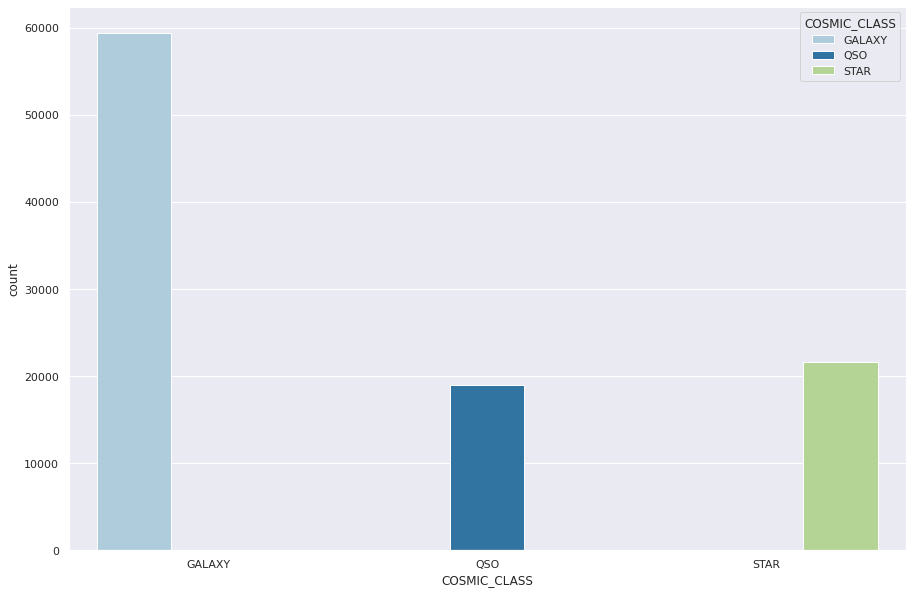

In [142]:
sns.countplot(x='COSMIC_CLASS', data=stellar_data, hue='COSMIC_CLASS')

<AxesSubplot: xlabel='alpha', ylabel='delta'>

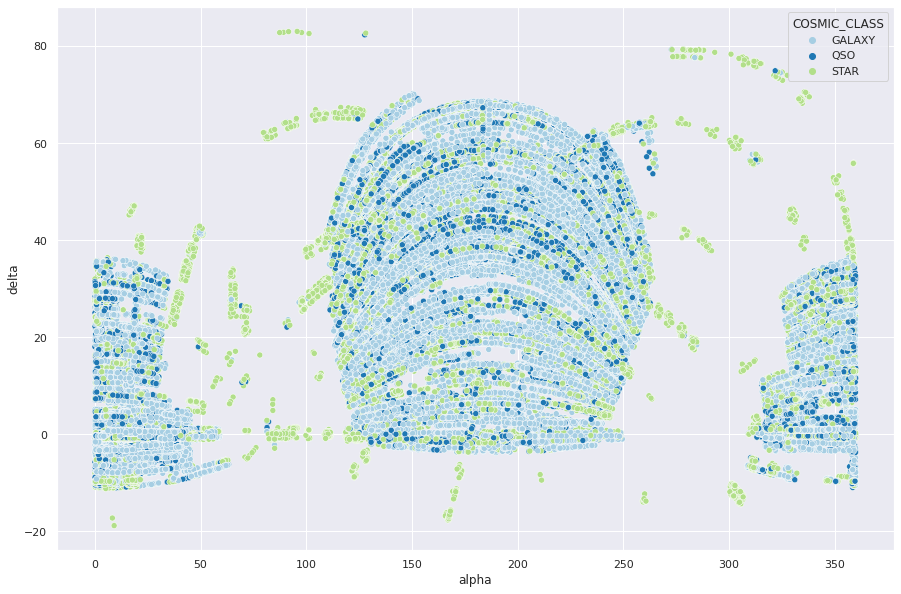

In [124]:
sns.scatterplot(x='alpha', y='delta', data=stellar_data, hue='COSMIC_CLASS')

### Verificando outliers nos dados do espectro eletromagnético

In [153]:
spectrum = stellar_data[['u','g','r','i','z','redshift','COSMIC_CLASS']]
spectrum.head(5)

,u,g,r,i,z,redshift,COSMIC_CLASS
0,23.87882,22.27530,20.39501,19.16573,18.79371,0.634794,GALAXY
1,24.77759,22.83188,22.58444,21.16812,21.61427,0.779136,GALAXY
2,25.26307,22.66389,20.60976,19.34857,18.94827,0.644195,GALAXY
3,22.13682,23.77656,21.61162,20.50454,19.25010,0.932346,GALAXY
4,19.43718,17.58028,16.49747,15.97711,15.54461,0.116123,GALAXY


<AxesSubplot: >

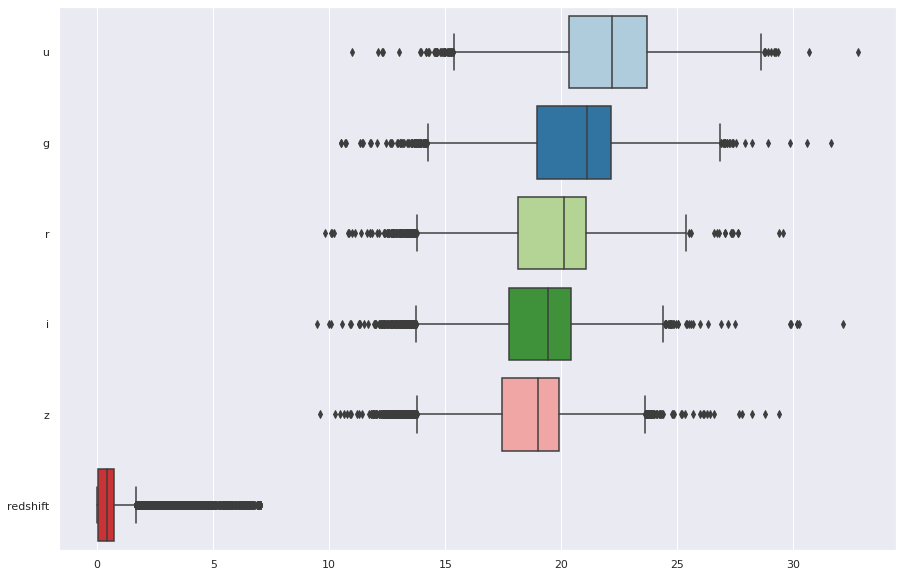

In [154]:
sns.boxplot(data=spectrum, orient='h')

<AxesSubplot: xlabel='redshift', ylabel='COSMIC_CLASS'>

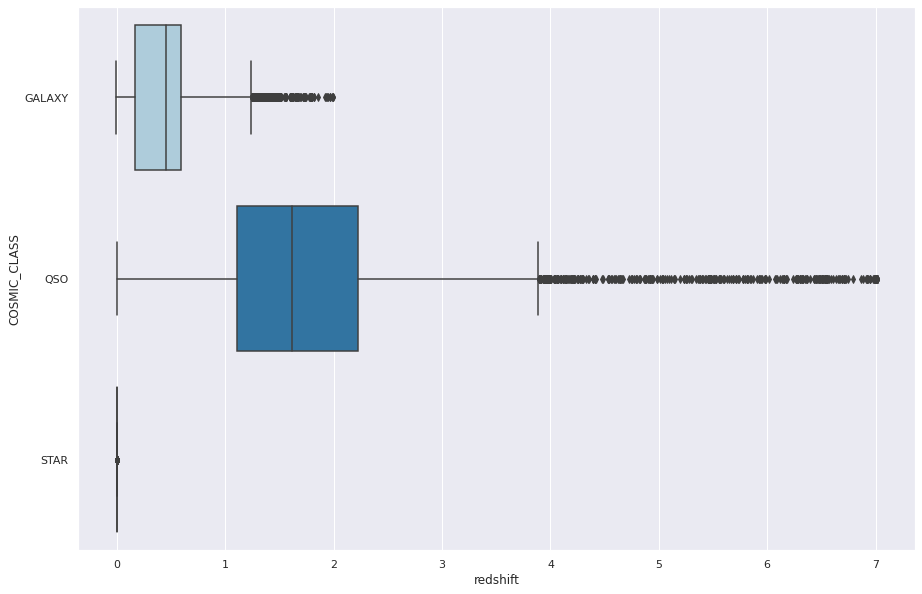

In [155]:
sns.boxplot(data=spectrum, x=spectrum['redshift'], y='COSMIC_CLASS', orient = 'h')

<AxesSubplot: xlabel='u', ylabel='COSMIC_CLASS'>

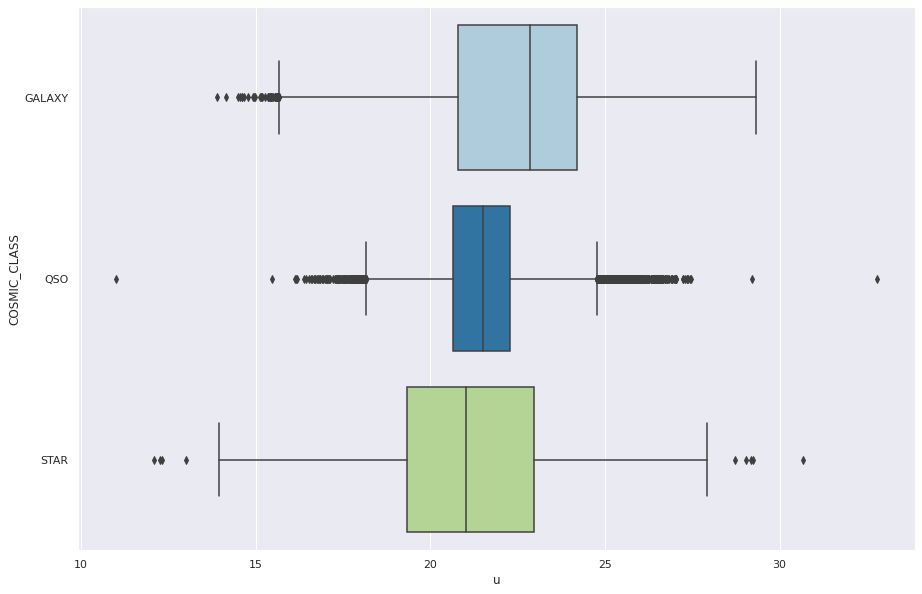

In [141]:
sns.boxplot(data=spectrum, x=spectrum['u'], y='COSMIC_CLASS', orient = 'h')

<AxesSubplot: xlabel='g', ylabel='COSMIC_CLASS'>

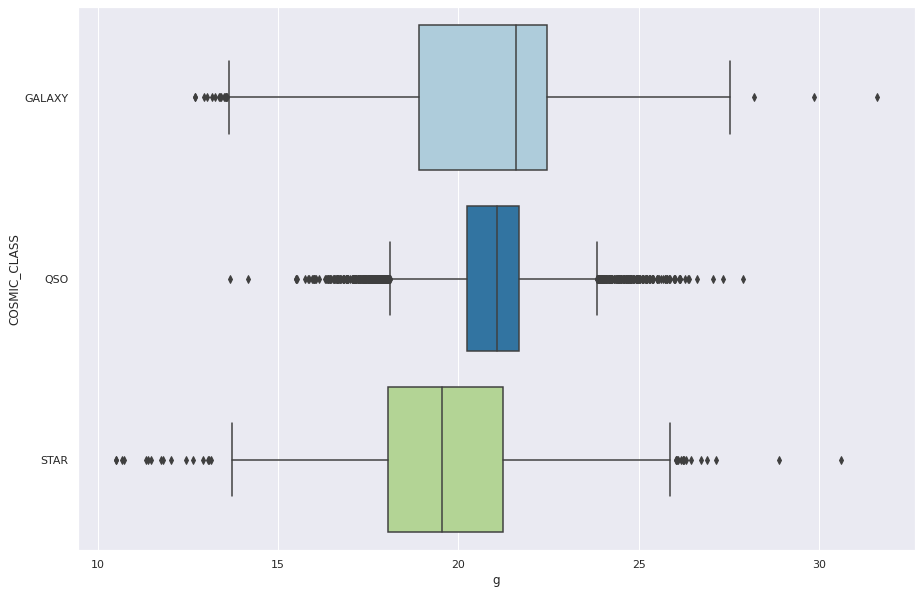

In [136]:
sns.boxplot(data=spectrum, x=spectrum['g'], y='COSMIC_CLASS', orient = 'h')

<AxesSubplot: xlabel='r', ylabel='COSMIC_CLASS'>

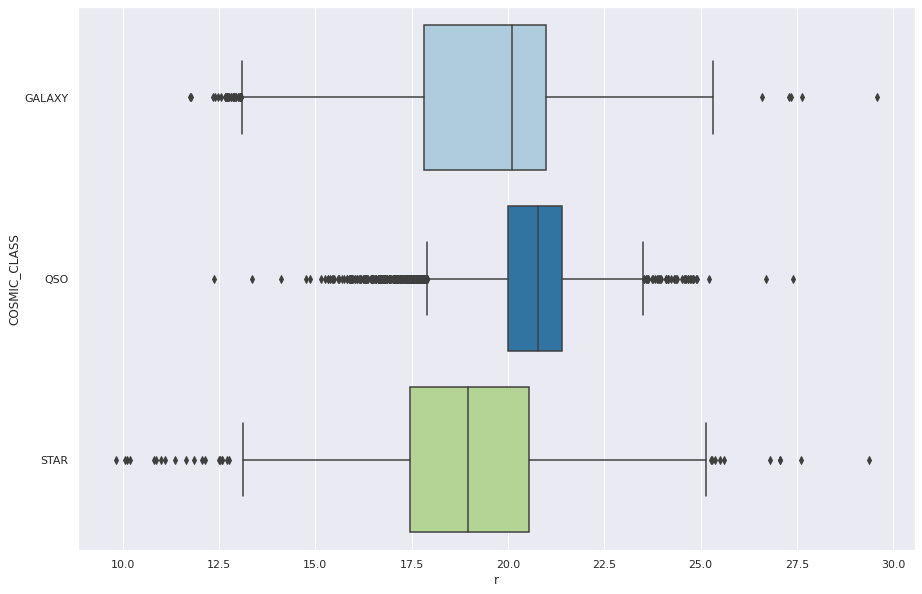

In [137]:
sns.boxplot(data=spectrum, x=spectrum['r'], y='COSMIC_CLASS', orient = 'h')

<AxesSubplot: xlabel='i', ylabel='COSMIC_CLASS'>

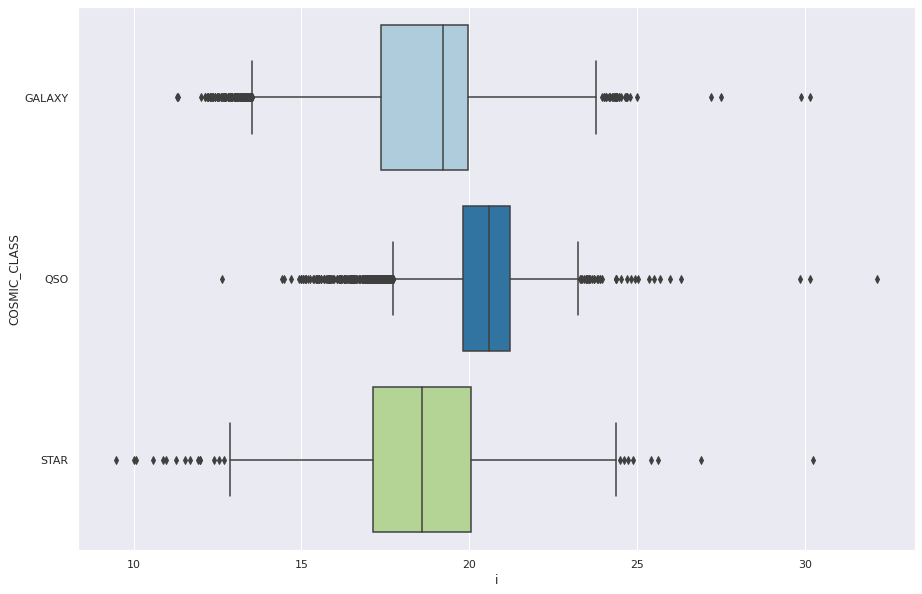

In [139]:
sns.boxplot(data=spectrum, x=spectrum['i'], y='COSMIC_CLASS', orient = 'h')

<AxesSubplot: xlabel='z', ylabel='COSMIC_CLASS'>

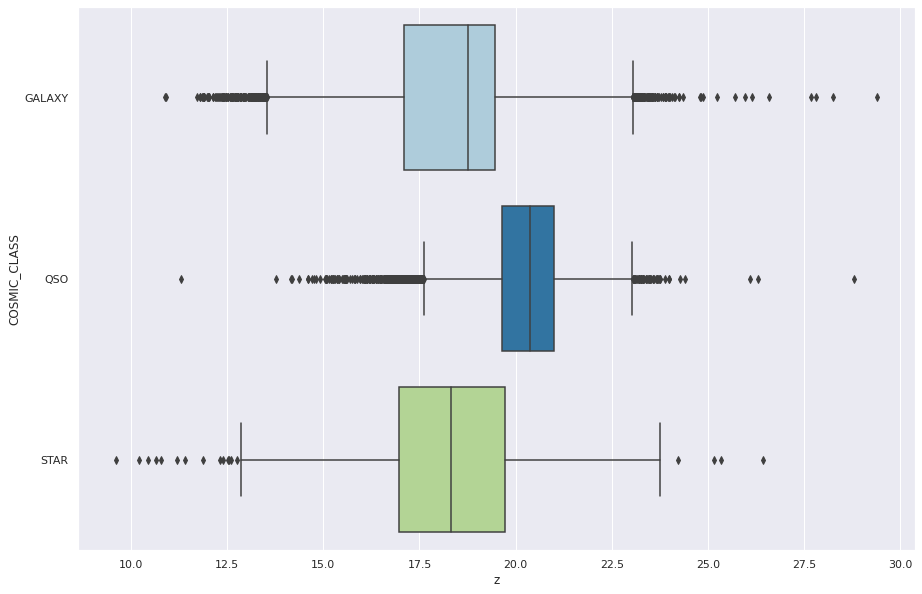

In [140]:
sns.boxplot(data=spectrum, x=spectrum['z'], y='COSMIC_CLASS', orient = 'h')

## Análise de features numéricas

In [146]:
spectrum.columns


Index(['u', 'g', 'r', 'i', 'z', 'COSMIC_CLASS'], dtype='object')

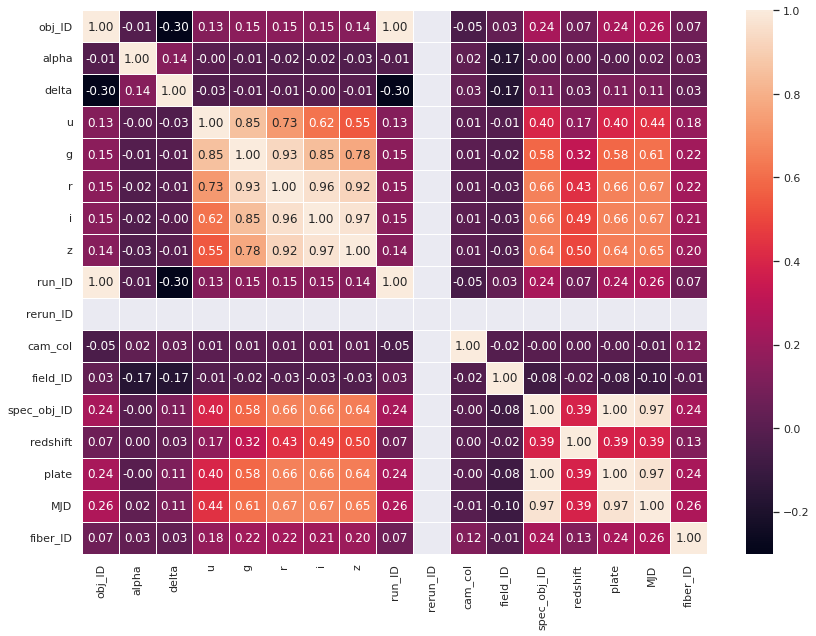

In [152]:
plt.figure(figsize = (14,10))
sns.heatmap(stellar_data.corr(), annot = True, fmt = ".2f", linewidths = 1)
plt.show()

